# Import Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
import requests
import csv
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [6]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Load Dataset

In [7]:
# URL dataset di GitHub
url = 'https://raw.githubusercontent.com/luckedenn/SentimentAnalysisIndodax/refs/heads/main/Dataset/indodax_reviews.csv'

# Membaca dataset menggunakan pandas
df = pd.read_csv(url)
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,1d41ae7e-3979-453d-964d-d98bd225719d,Awan Clover,https://play-lh.googleusercontent.com/a-/ALV-U...,"indodax lumayan enak sih buat pemula terutama,...",5,0,5.4.8,2025-04-04 09:42:55,Dear member INDODAX. Terima kasih atas partisi...,2025-04-04 09:49:51,5.4.8
1,fd75d2e1-b08c-4492-acc6-6ab200665807,Eko Prasetiyo,https://play-lh.googleusercontent.com/a/ACg8oc...,username: godless666 berinvestasi di indodax s...,5,0,5.4.8,2025-04-04 09:14:31,Dear member INDODAX. Terima kasih atas review ...,2025-04-02 09:09:40,5.4.8
2,5cd4ce7b-f8d0-4c6e-aeed-37fc376bf04c,indra ciby,https://play-lh.googleusercontent.com/a-/ALV-U...,maaf saya turunin kenapa sekarang sering harus...,1,0,5.4.8,2025-04-04 09:14:21,Dear member INDODAX. Terima kasih atas review ...,2025-02-19 02:00:46,5.4.8
3,ce7d10ac-2984-494b-acea-f17ac6fcc912,Muhammad Fahrezi,https://play-lh.googleusercontent.com/a/ACg8oc...,loading data lama,1,0,5.4.8,2025-04-04 08:47:45,"Dear member INDODAX, mohon maaf atas ketidakny...",2025-04-04 08:50:02,5.4.8
4,33ebe9e8-4213-4cf2-ad7b-da7aac08f2ac,zhemz pisces,https://play-lh.googleusercontent.com/a/ACg8oc...,Mudahnya investasi dengan indodax mobile app.u...,5,0,5.4.8,2025-04-04 08:25:13,Dear member INDODAX. Terima kasih atas review ...,2025-04-04 08:36:51,5.4.8


# EDA

In [8]:
print("Dataset shape:", df.shape)

Dataset shape: (15000, 11)


In [9]:
# Display basic info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              15000 non-null  object
 1   userName              15000 non-null  object
 2   userImage             15000 non-null  object
 3   content               15000 non-null  object
 4   score                 15000 non-null  int64 
 5   thumbsUpCount         15000 non-null  int64 
 6   reviewCreatedVersion  11775 non-null  object
 7   at                    15000 non-null  object
 8   replyContent          15000 non-null  object
 9   repliedAt             15000 non-null  object
 10  appVersion            11775 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB
None


In [10]:
# Descriptive statistics for numerical columns
print(df.describe())

              score  thumbsUpCount
count  15000.000000    15000.00000
mean       4.400000        0.33500
std        1.307713        2.83431
min        1.000000        0.00000
25%        5.000000        0.00000
50%        5.000000        0.00000
75%        5.000000        0.00000
max        5.000000       32.00000


In [11]:
# Menghapus kolom yang tidak relevan
df = df.drop(columns=[col for col in df.columns if col not in ['score', 'userName', 'content']])

In [12]:
# Check for missing values
print(df.isnull().sum())

userName    0
content     0
score       0
dtype: int64


# Preprocessing

In [13]:
# Text cleaning functions
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # remove hashtag
    text = re.sub(r'RT[\s]', '', text)  # remove RT
    text = re.sub(r"http\S+", '', text)  # remove link
    text = re.sub(r'[0-9]+', '', text)  # remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # remove special characters
    text = text.replace('\n', ' ')  # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuations
    text = text.strip(' ')  # remove leading/trailing spaces
    return text

def casefoldingText(text):
    text = text.lower()  # lowercase
    return text

def tokenizingText(text):
    text = word_tokenize(text)  # tokenize
    return text

def filteringText(text):
    # Combined stopwords from Indonesian and English
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])

    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    return filtered

def stemmingText(text):
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text


def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [14]:
# Load slang words dictionary from GitHub
def load_slangwords(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Gagal memuat slang words. Status code: {response.status_code}")

# GitHub raw URL for slang words
slang_url = "https://raw.githubusercontent.com/luckedenn/SentimentAnalysisIndodax/refs/heads/main/Dataset/slang.json"
slangwords = load_slangwords(slang_url)

# Normalisasi teks dengan mengganti slang words
def fix_slangwords(text):
    words = text.split()
    fixed_words = [slangwords.get(word.lower(), word) for word in words]
    return ' '.join(fixed_words)

In [15]:
# Create a clean dataframe
clean_df = df.copy()

In [16]:
# Perform text preprocessing
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

print("Sample preprocessed text:")
print(clean_df[['content', 'text_akhir']].head(2))

Sample preprocessed text:
                                             content  \
0  indodax lumayan enak sih buat pemula terutama,...   
1  username: godless666 berinvestasi di indodax s...   

                                          text_akhir  
0  indodax lumayan enak pemula segi tampilannya f...  
1  username godless berinvestasi indodax mudah ga...  


In [17]:
# Read positive and negative lexicon data
lexicon_positive = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [18]:
# Fungsi untuk menentukan polaritas sentimen dari teks
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]

    # Modified to have three classes instead of two
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

In [19]:
# Apply lexicon-based sentiment analysis
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print("Sentiment distribution:")
print(clean_df['polarity'].value_counts())

Sentiment distribution:
polarity
positive    8400
negative    4725
neutral     1875
Name: count, dtype: int64


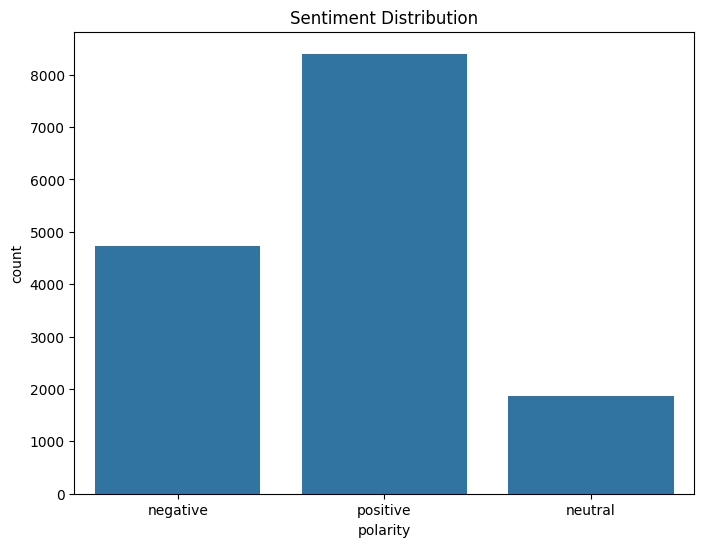

In [20]:
# Visualize sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='polarity', data=clean_df)
plt.title('Sentiment Distribution')
plt.show()

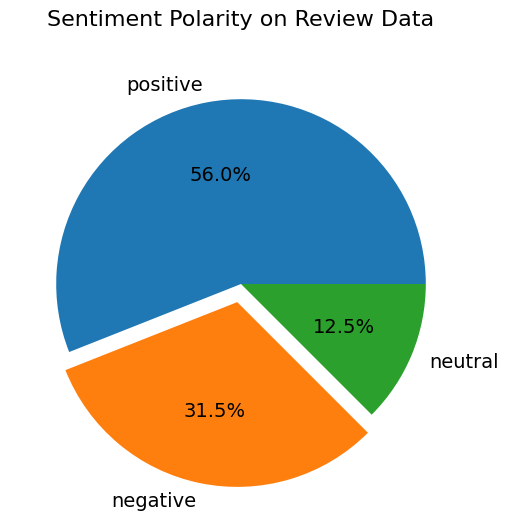

In [21]:
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'clean_df'
sizes = [count for count in clean_df['polarity'].value_counts()]
labels = list(clean_df['polarity'].value_counts().index)

# Membuat explode otomatis: 0.1 untuk 'negative', 0 untuk lainnya
explode = [0.1 if label.lower() == 'negative' else 0 for label in labels]

# Membuat pie chart
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Menambahkan judul
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)

# Menampilkan plot
plt.show()

In [22]:
# Mengatur opsi tampilan Pandas
pd.set_option('display.max_colwidth', 3000)

# Membuat fungsi bantu untuk memproses tweet berdasarkan polaritas
def get_tweets_by_polarity(df, polarity, ascending=True, top_n=10):
    tweets = df[df['polarity'] == polarity]
    tweets = tweets[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]
    tweets = tweets.sort_values(by='polarity_score', ascending=ascending)
    tweets = tweets.head(top_n).reset_index(drop=True)
    tweets.index += 1
    return tweets

# Ambil tweet berdasarkan polaritas
positive_tweets = get_tweets_by_polarity(clean_df, 'positive', ascending=False)
negative_tweets = get_tweets_by_polarity(clean_df, 'negative', ascending=True)
neutral_tweets = get_tweets_by_polarity(clean_df, 'neutral', ascending=False)

# Fungsi bantu untuk generate WordCloud dari list tweet
def generate_wordcloud(tweets_df, title):
    list_words = ''
    for tweet in tweets_df['text_stopword']:
        for word in tweet:
            list_words += ' ' + word

    wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title, fontsize=18)
    ax.grid(False)
    ax.imshow(wordcloud)
    ax.axis('off')
    fig.tight_layout(pad=0)
    plt.show()

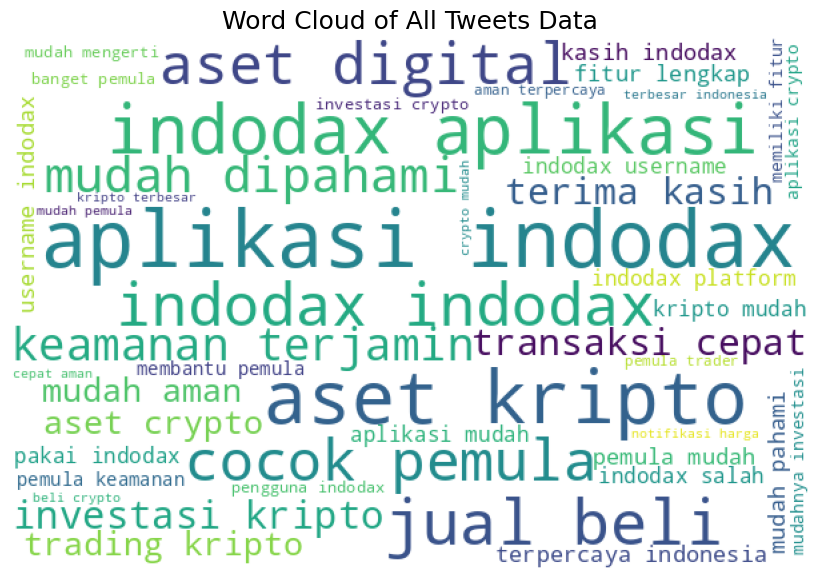

In [23]:
# WordCloud untuk semua kategori
generate_wordcloud(clean_df, 'Word Cloud of All Tweets Data')

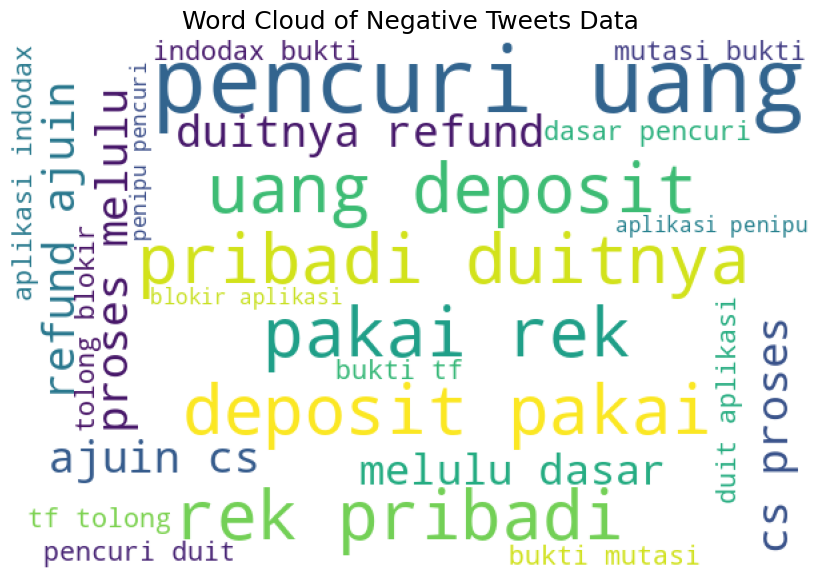

In [24]:
generate_wordcloud(negative_tweets, 'Word Cloud of Negative Tweets Data')

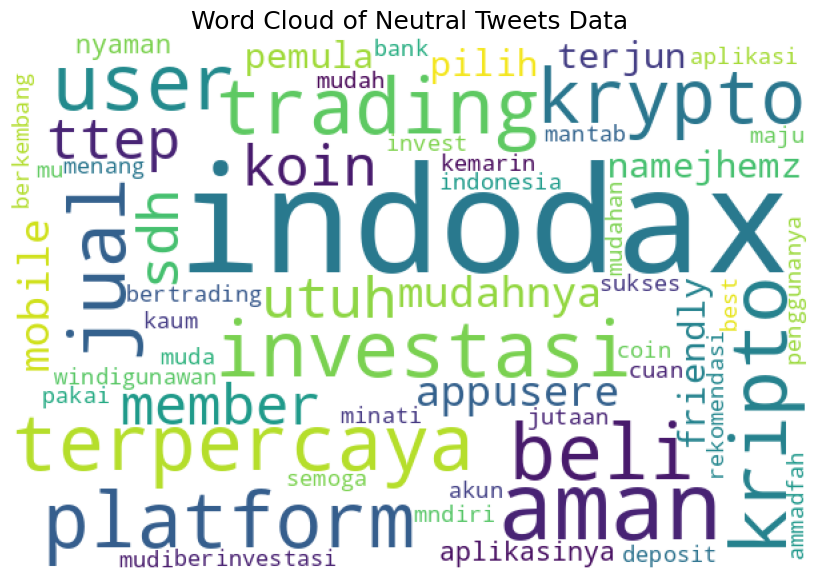

In [25]:
generate_wordcloud(neutral_tweets, 'Word Cloud of Neutral Tweets Data')

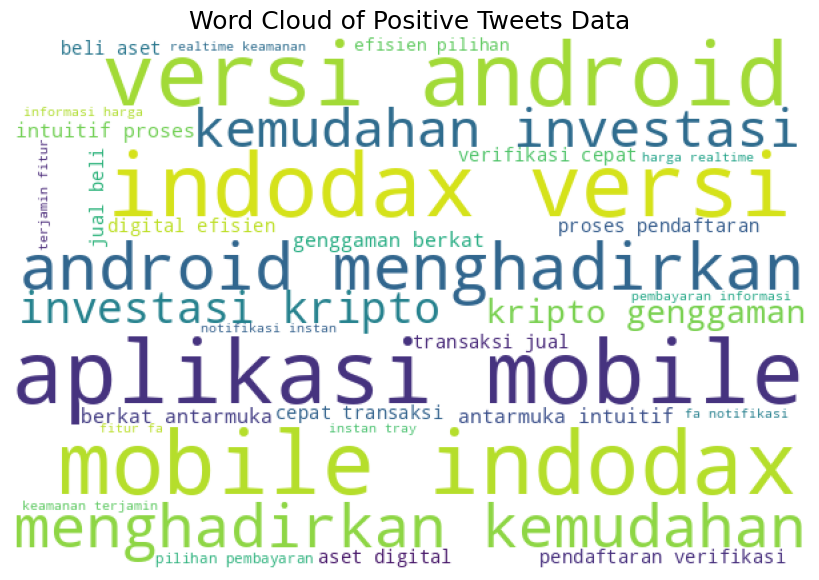

In [26]:
generate_wordcloud(positive_tweets, 'Word Cloud of Positive Tweets Data')

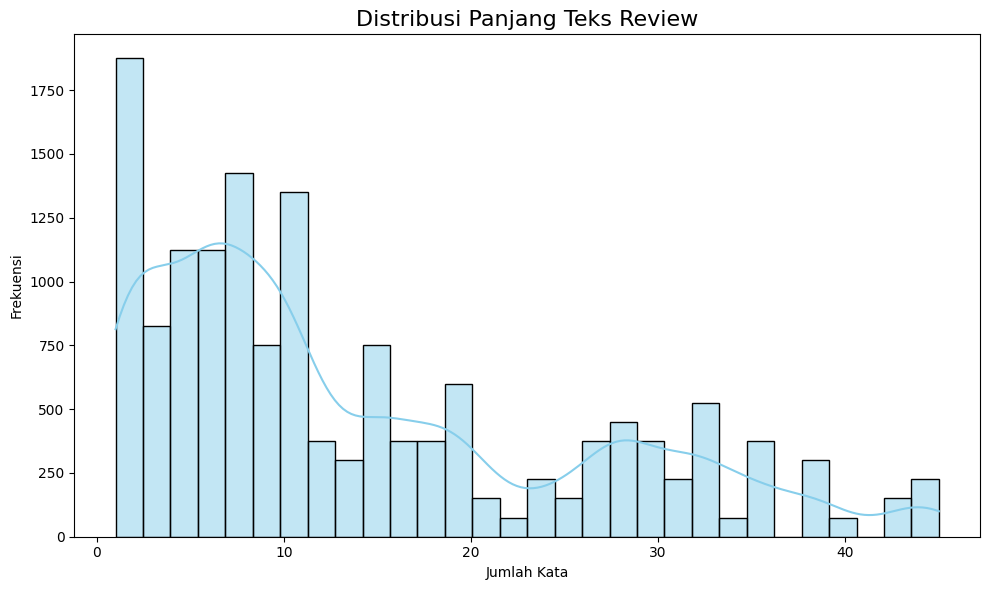

In [27]:
# Menambahkan kolom panjang teks
clean_df['text_length'] = clean_df['text_akhir'].apply(lambda x: len(x.split()))

# Visualisasi distribusi panjang teks
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(clean_df['text_length'], bins=30, kde=True, ax=ax, color='skyblue')
ax.set_title('Distribusi Panjang Teks Review', fontsize=16)
ax.set_xlabel('Jumlah Kata')
ax.set_ylabel('Frekuensi')
plt.tight_layout()
plt.show()

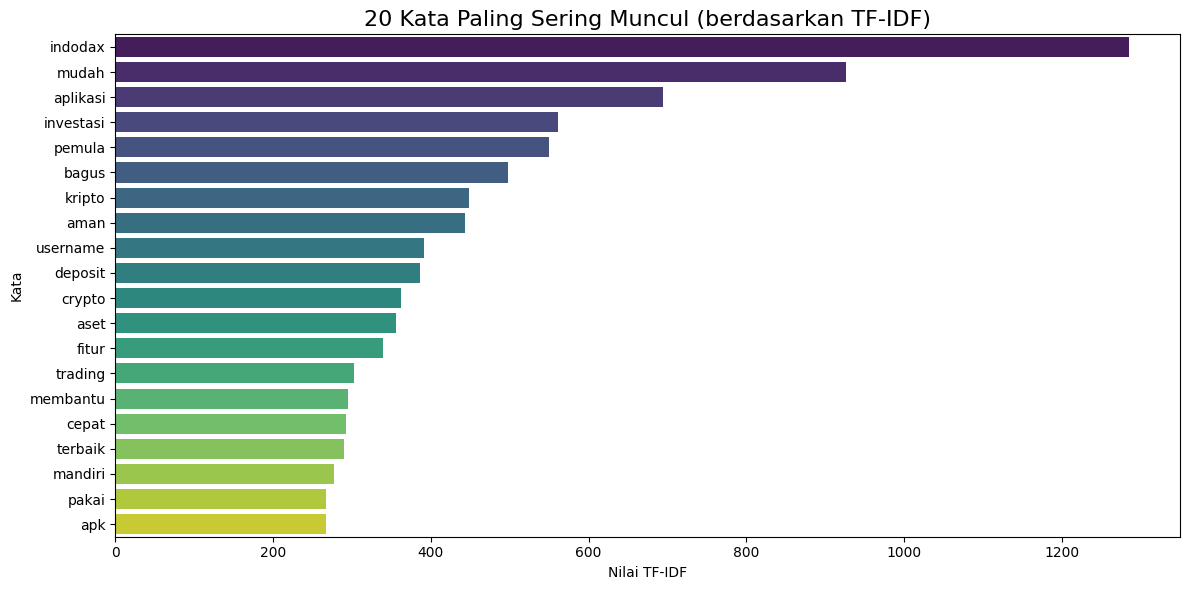

In [28]:
# TF-IDF untuk kata paling sering muncul
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text_akhir'])

# Buat DataFrame dari hasil TF-IDF
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_sum = tfidf_df.sum().reset_index(name='jumlah')
tfidf_sum = tfidf_sum.rename(columns={'index': 'kata'})

# Ambil 20 kata teratas
tfidf_top20 = tfidf_sum.sort_values('jumlah', ascending=False).head(20)

# Visualisasi
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='jumlah', y='kata', data=tfidf_top20, ax=ax, palette='viridis')
ax.set_title('20 Kata Paling Sering Muncul (berdasarkan TF-IDF)', fontsize=16)
ax.set_xlabel('Nilai TF-IDF')
ax.set_ylabel('Kata')
plt.tight_layout()
plt.show()

# Training and Modelling

In [29]:
# Data for model training
X = clean_df['text_akhir']
y = clean_df['polarity']

In [30]:
#split dataset
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [32]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=500, min_df=5, max_df=0.85)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

## Random Forest + TF-IDF

In [36]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

y_train_pred_rf = rf_model.predict(X_train_tfidf)
y_test_pred_rf = rf_model.predict(X_test_tfidf)

rf_train_acc = accuracy_score(y_train, y_train_pred_rf)
rf_test_acc = accuracy_score(y_test, y_test_pred_rf)

print(f"Random Forest - Train Accuracy: {rf_train_acc:.4f}")
print(f"Random Forest - Test Accuracy: {rf_test_acc:.4f}")
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_test_pred_rf))

Random Forest - Train Accuracy: 0.9952
Random Forest - Test Accuracy: 0.9943

Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.98      0.99       945
     neutral       0.96      1.00      0.98       375
    positive       1.00      1.00      1.00      1680

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



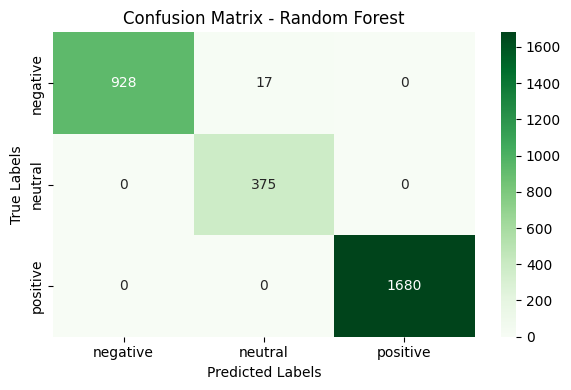

In [38]:
cm_rf = confusion_matrix(y_test, y_test_pred_rf, labels=rf_model.classes_)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d',
            xticklabels=rf_model.classes_,
            yticklabels=rf_model.classes_,
            cmap='Greens')

plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

##Logistic Regression + TF-IDF

In [35]:
lr_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

y_train_pred_lr = lr_model.predict(X_train_tfidf)
y_test_pred_lr = lr_model.predict(X_test_tfidf)

lr_train_acc = accuracy_score(y_train, y_train_pred_lr)
lr_test_acc = accuracy_score(y_test, y_test_pred_lr)

print(f"\nLogistic Regression - Train Accuracy: {lr_train_acc:.4f}")
print(f"Logistic Regression - Test Accuracy: {lr_test_acc:.4f}")
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_test_pred_lr))


Logistic Regression - Train Accuracy: 0.9950
Logistic Regression - Test Accuracy: 0.9950

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.98      1.00      0.99       945
     neutral       1.00      0.96      0.98       375
    positive       1.00      1.00      1.00      1680

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       1.00      0.99      0.99      3000



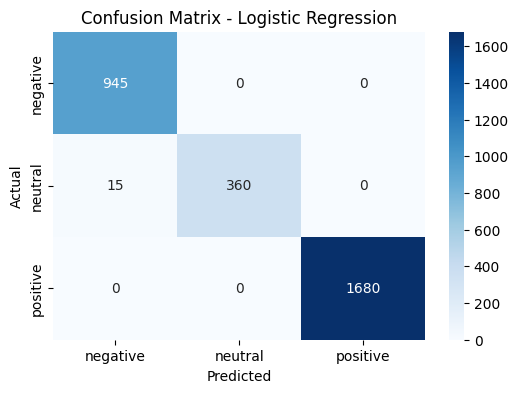

In [37]:
cm = confusion_matrix(y_test, y_test_pred_lr, labels=lr_model.classes_)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=lr_model.classes_, yticklabels=lr_model.classes_, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- LSTM with Word Embeddings

In [39]:
# Set maximum sequence length and vocabulary size
max_features = 5000
maxlen = 100

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=maxlen)

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_pad, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [40]:
# Define LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(max_features, 128, input_length=maxlen))
lstm_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 30s 78ms/step - accuracy: 0.7811 - loss: 0.5379 - val_accuracy: 1.0000 - val_loss: 7.7603e-04
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.9996 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 3.8208e-06
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 4.3812e-06
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - accuracy: 0.9990 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 7.8856e-07
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.9994 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 2.0186e-07
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.9996 - loss: 8.7381e-04 - val_accuracy: 1.0000 - val_loss: 2.6822e-08
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - accuracy: 0.9992 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 1.0928e-09
Epoch 8/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - ac

In [41]:
# Evaluate LSTM model
lstm_train_loss, lstm_train_acc = lstm_model.evaluate(X_train_seq, y_train_seq, verbose=0)
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_seq, y_test_seq, verbose=0)

print(f"LSTM - Train Accuracy: {lstm_train_acc:.4f}")
print(f"LSTM - Test Accuracy: {lstm_test_acc:.4f}")


LSTM - Train Accuracy: 1.0000
LSTM - Test Accuracy: 1.0000


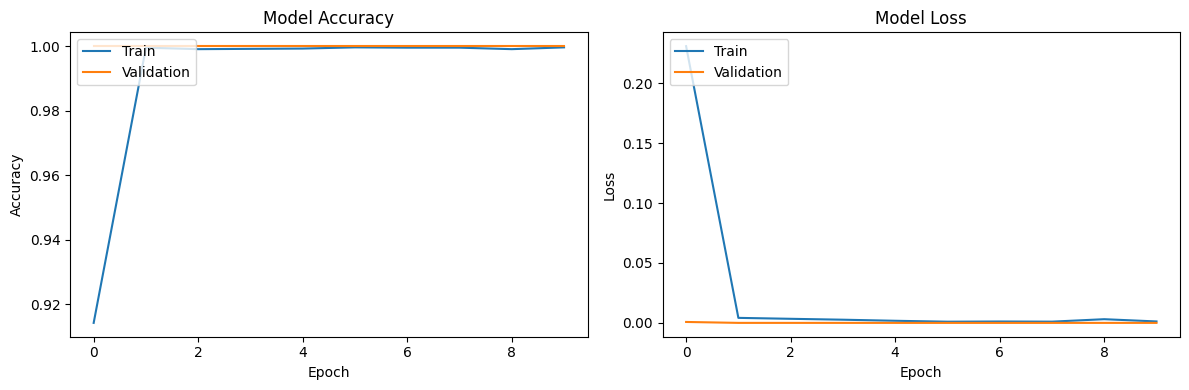

In [42]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [43]:
# Define Bidirectional LSTM model
bi_lstm_model = Sequential()
bi_lstm_model.add(Embedding(max_features, 128, input_length=maxlen))
bi_lstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bi_lstm_model.add(Bidirectional(LSTM(32)))
bi_lstm_model.add(Dense(64, activation='relu'))
bi_lstm_model.add(Dropout(0.5))
bi_lstm_model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
bi_lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
bi_lstm_history = bi_lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.7781 - loss: 0.4996 - val_accuracy: 1.0000 - val_loss: 1.6190e-04
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 82s 127ms/step - accuracy: 0.9996 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 7.2606e-06
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - accuracy: 1.0000 - loss: 6.1977e-04 - val_accuracy: 1.0000 - val_loss: 1.4573e-06
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 43s 127ms/step - accuracy: 1.0000 - loss: 4.4345e-04 - val_accuracy: 1.0000 - val_loss: 4.9651e-07
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 81s 126ms/step - accuracy: 1.0000 - loss: 7.5056e-04 - val_accuracy: 1.0000 - val_loss: 1.7196e-07
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - accuracy: 1.0000 - loss: 3.0556e-04 - val_accuracy: 1.0000 - val_loss: 4.0432e-08
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 82s 127ms/step - accuracy: 1.0000 - loss: 1.5657e-04 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
338/338 ━━━━━━━━━━━━━━━━

In [44]:
# Evaluate BiLSTM model
bi_lstm_train_loss, bi_lstm_train_acc = bi_lstm_model.evaluate(X_train_seq, y_train_seq, verbose=0)
bi_lstm_test_loss, bi_lstm_test_acc = bi_lstm_model.evaluate(X_test_seq, y_test_seq, verbose=0)

print(f"Bidirectional LSTM - Train Accuracy: {bi_lstm_train_acc:.4f}")
print(f"Bidirectional LSTM - Test Accuracy: {bi_lstm_test_acc:.4f}")

Bidirectional LSTM - Train Accuracy: 1.0000
Bidirectional LSTM - Test Accuracy: 1.0000


In [45]:
# Get predictions
y_pred_train_bi_lstm = bi_lstm_model.predict(X_train_seq)
y_pred_train_bi_lstm = np.argmax(y_pred_train_bi_lstm, axis=1)
y_pred_test_bi_lstm = bi_lstm_model.predict(X_test_seq)
y_pred_test_bi_lstm = np.argmax(y_pred_test_bi_lstm, axis=1)

# Convert back to original labels for classification report
y_test_bi_lstm_orig = label_encoder.inverse_transform(y_test_seq)
y_pred_test_bi_lstm_orig = label_encoder.inverse_transform(y_pred_test_bi_lstm)

375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step



Bidirectional LSTM Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       945
     neutral       1.00      1.00      1.00       375
    positive       1.00      1.00      1.00      1680

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



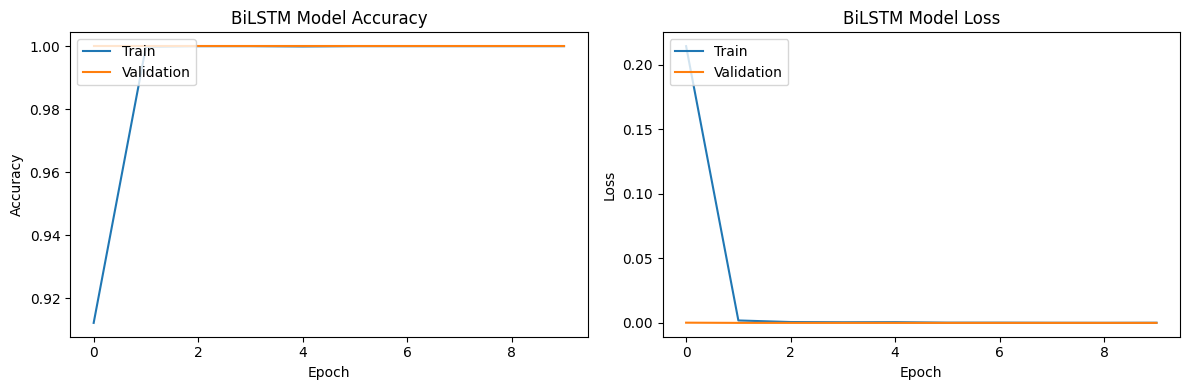

In [46]:
print("\nBidirectional LSTM Classification Report:")
print(classification_report(y_test_bi_lstm_orig, y_pred_test_bi_lstm_orig))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(bi_lstm_history.history['accuracy'])
plt.plot(bi_lstm_history.history['val_accuracy'])
plt.title('BiLSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(bi_lstm_history.history['loss'])
plt.plot(bi_lstm_history.history['val_loss'])
plt.title('BiLSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

## Model Performance Summary

                          Model  Train Accuracy  Test Accuracy
3            Bidirectional LSTM        1.000000       1.000000
2                          LSTM        1.000000       1.000000
1  Logistic Regression (TF-IDF)        0.995000       0.995000
0        Random Forest (TF-IDF)        0.995167       0.994333


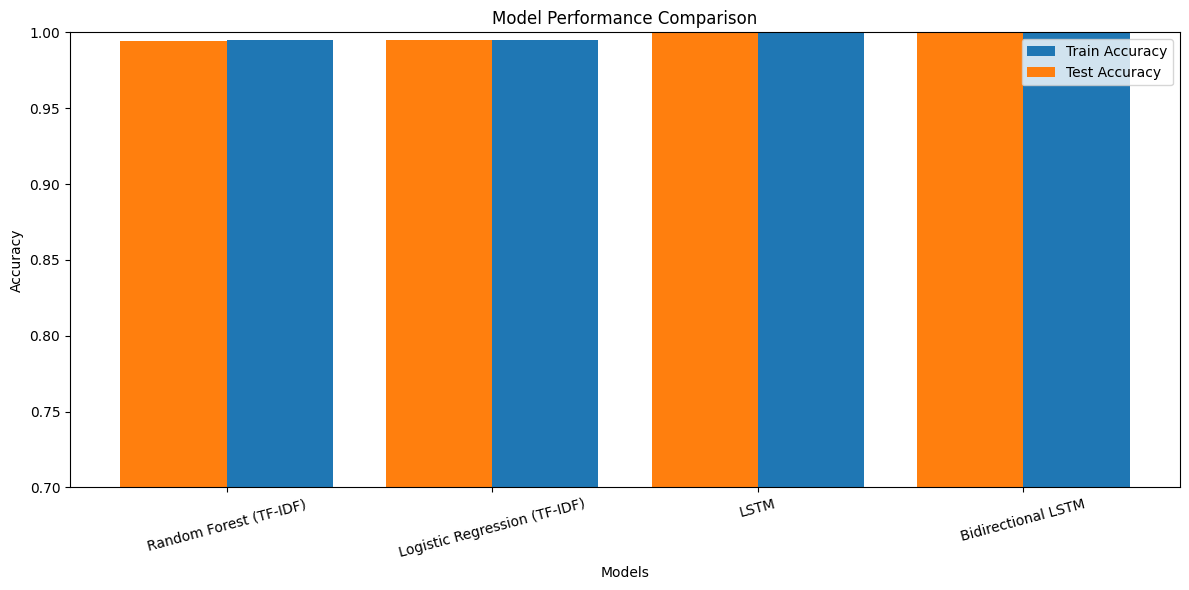

In [47]:
# Create a DataFrame to compare all models
results_df = pd.DataFrame({
    'Model': ['Random Forest (TF-IDF)', 'Logistic Regression (TF-IDF)', 'LSTM', 'Bidirectional LSTM'],
    'Train Accuracy': [rf_train_acc, lr_train_acc, lstm_train_acc, bi_lstm_train_acc],
    'Test Accuracy': [rf_test_acc, lr_test_acc, lstm_test_acc, bi_lstm_test_acc]
})

# Display and sort by test accuracy
results_sorted = results_df.sort_values(by='Test Accuracy', ascending=False)
print(results_sorted)

# Plot comparison of models
plt.figure(figsize=(12, 6))
plt.bar(results_df['Model'], results_df['Train Accuracy'], width=0.4, label='Train Accuracy', align='edge')
plt.bar(results_df['Model'], results_df['Test Accuracy'], width=-0.4, label='Test Accuracy', align='edge')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0.7, 1.0)  # Set y-axis limits for better visualization
plt.legend()
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


# Inference Testing


In [48]:
# Function to preprocess new text
def preprocess_new_text(text):
    text_cleaned = cleaningText(text)
    text_casefolded = casefoldingText(text_cleaned)
    text_slangfixed = fix_slangwords(text_casefolded)
    text_tokenized = tokenizingText(text_slangfixed)
    text_filtered = filteringText(text_tokenized)
    text_final = toSentence(text_filtered)
    return text_final

In [57]:
# Test with some example sentences
test_sentences = [
    "indodax mudah digunakan",
    "Sering error dasar aplikasi penipu",
    "Biasa saja, tidak ada yang spesial"
]

In [58]:
print("Testing inference with example sentences:")
for sentence in test_sentences:
    print(f"\nOriginal text: {sentence}")

    # Preprocess the text
    processed_text = preprocess_new_text(sentence)
    print(f"Preprocessed: {processed_text}")

    # Get predictions from each model
    # 1. Random Forest with TF-IDF
    tfidf_vector = tfidf.transform([processed_text])
    rf_pred = rf_model.predict(tfidf_vector)[0]

    # 2. Logistic Regression with TF-IDF
    lr_pred = lr_model.predict(tfidf_vector)[0]

    # 3. LSTM
    seq = tokenizer.texts_to_sequences([processed_text])
    padded_seq = pad_sequences(seq, maxlen=maxlen)
    lstm_pred_encoded = np.argmax(lstm_model.predict(padded_seq), axis=1)[0]
    lstm_pred = label_encoder.inverse_transform([lstm_pred_encoded])[0]

    # 4. Bidirectional LSTM
    bi_lstm_pred_encoded = np.argmax(bi_lstm_model.predict(padded_seq), axis=1)[0]
    bi_lstm_pred = label_encoder.inverse_transform([bi_lstm_pred_encoded])[0]

    # Print results
    print(f"Random Forest prediction: {rf_pred}")
    print(f"Logistic Regression prediction: {lr_pred}")
    print(f"LSTM prediction: {lstm_pred}")
    print(f"Bidirectional LSTM prediction: {bi_lstm_pred}")

Testing inference with example sentences:

Original text: indodax mudah digunakan
Preprocessed: indodax mudah
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Random Forest prediction: positive
Logistic Regression prediction: positive
LSTM prediction: positive
Bidirectional LSTM prediction: positive

Original text: Sering error dasar aplikasi penipu
Preprocessed: error dasar aplikasi penipu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Random Forest prediction: negative
Logistic Regression prediction: negative
LSTM prediction: negative
Bidirectional LSTM prediction: negative

Original text: Biasa saja, tidak ada yang spesial
Preprocessed: spesial
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Random Forest prediction: neutral
Logistic Regression prediction: negative
LSTM prediction: neutral
Bidirectional LSTM prediction: neutral


In [53]:
# Interactive user input for testing
print("\n")
user_input = input("Masukkan kalimat untuk dianalisis sentimen: ")

# Preprocess user input
processed_input = preprocess_new_text(user_input)

# Get predictions from best model (based on previous results)
tfidf_vector = tfidf.transform([processed_input])
rf_pred = rf_model.predict(tfidf_vector)[0]

# Convert to sequence for LSTM models
seq = tokenizer.texts_to_sequences([processed_input])
padded_seq = pad_sequences(seq, maxlen=maxlen)
bi_lstm_pred_encoded = np.argmax(bi_lstm_model.predict(padded_seq), axis=1)[0]
bi_lstm_pred = label_encoder.inverse_transform([bi_lstm_pred_encoded])[0]

print(f"\nHasil analisis sentimen dengan Random Forest: {rf_pred}")
print(f"Hasil analisis sentimen dengan Bidirectional LSTM: {bi_lstm_pred}")



Masukkan kalimat untuk dianalisis sentimen: indodax mudah digunakan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Hasil analisis sentimen dengan Random Forest: positive
Hasil analisis sentimen dengan Bidirectional LSTM: positive


### Kesimpulan Hasil Evaluasi Model Sentimen

Berdasarkan hasil akurasi dari keempat model yang diuji, berikut adalah rangkuman performanya:

| Model                             | Akurasi Training | Akurasi Testing |
|----------------------------------|------------------|-----------------|
| **Bidirectional LSTM**           | 100.00%          | 100.00%         |
| **LSTM**                         | 100.00%          | 100.00%         |
| **Logistic Regression (TF-IDF)** | 99.50%           | 99.50%          |
| **Random Forest (TF-IDF)**       | 99.52%           | 99.43%          |

---

### Analisis dan Interpretasi

1. **Model Deep Learning (LSTM & BiLSTM)**  
   - Mencapai akurasi sempurna (100%) baik pada data pelatihan maupun pengujian.
   - Hal ini menunjukkan bahwa model sangat baik dalam mengenali pola data, namun juga perlu diwaspadai kemungkinan **overfitting**, terutama jika jumlah data tidak besar atau tidak beragam.
   - BiLSTM tidak menunjukkan peningkatan signifikan dibandingkan LSTM biasa.

2. **Model Machine Learning Tradisional (TF-IDF + Classifier)**  
   - Logistic Regression dan Random Forest menunjukkan performa yang sangat baik meskipun sedikit di bawah LSTM.
   - Ini membuktikan bahwa fitur **TF-IDF** cukup representatif untuk kasus analisis sentimen, terutama dengan data yang terbatas.


